In [1]:
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import torch
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16, VGG, VGG16_Weights
from torchvision import transforms
from scipy import ndimage
from PIL import Image as pil
import numpy as np
from tqdm import tqdm
import ast

In [4]:
import cv2

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = (20,10) # set default size of plots

### Наши обычные действия при оптимизации функции потерь нейросети:

### Вместо этого будем считать градиенты по другим тензорам

Во фреймворке Pytorch ккласс `torch.Tensor` имеет поле `grad` в котором хранится градиент. По умолчанию значение поля `None`

In [6]:
random_tensor = torch.rand((1,3,224,224))

In [7]:
random_tensor.grad is None

True

У класса `torch.Tensor` так же есть поле `requires_grad` указывающее на то необходимо ли вычислять градиент для данного тензора в ходе backpropagation.

In [8]:
random_tensor.requires_grad

False

Мы можем видеть, что сейчас тензор является константой с точки зрения Pytorch. Переключим его в другой режим

In [9]:
random_tensor = random_tensor.requires_grad_(True)

In [10]:
random_tensor2 = torch.rand((1,3,224,224))

In [11]:
random_tensor2 = random_tensor2.requires_grad_(True)

Метод `backward()` класса `torch.Tensor` необходим для вычисления градиента по всем тензорам со значением `random_tensor.requires_grad == True`

Реализация Pytorch и движка autograd позволяют вычислять градиент только от скалярных функций. Чтобы пример выполнялся необходимо тем или иным образом агрегировать значения тензора. Например, просуммировав:

In [12]:
y = random_tensor.sum()

Таким образом мы задали функцию 
$$y = \sum x_{i,j,k,m} $$ 
Теперь вызов `y.backward()` рассчитает градиент 
$$\nabla_x y$$
и заполнит поле `grad` у переменной `random_tensor`

In [19]:
y.backward()

In [15]:
random_tensor.grad is None, random_tensor.grad.shape

(False, torch.Size([1, 3, 224, 224]))

In [16]:
random_tensor2.grad is None

True

In [20]:
random_tensor.grad

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

Ожидаемо получаем тензор заполненный 1. Если вызвать `y.backward()` повторно, то вычисленный градиент прибавится ко значению, находящемуся в `random_tensor.grad`

In [23]:
random_tensor.grad = None

In [34]:
y2 = torch.square(random_tensor).sum()

Таким образом мы задали функцию 
$$y_2 = \sum x_{i,j,k,m}^2 $$ 
Теперь вызов `y2.backward()` рассчитает градиент 
$$\nabla_x y_2$$
и заполнит поле `grad` у переменной `random_tensor`

Ожидаем, что эти градиенты будут следующими:
$$\nabla_x y_2 = 2*x$$

то есть, должно выполняться следующее равенство:
$$\frac{\nabla_x y_2}{2x} = 1,$$

где $1$ - это матрица размером с $x$, в каждой позиции которой стоит единица.

In [35]:
random_tensor.grad=None

In [36]:
y2.backward()

In [38]:
(random_tensor.grad)/(2*random_tensor)

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], grad_fn=<DivBackward0>)

Действительно, так и есть!

In [39]:
y.backward()
random_tensor.grad

tensor([[[[2.7090, 1.7084, 1.7122,  ..., 1.3147, 2.6860, 2.3309],
          [1.2665, 1.5861, 2.9694,  ..., 1.9647, 1.5539, 2.4105],
          [2.1304, 2.3867, 2.6225,  ..., 1.4947, 1.9305, 2.2580],
          ...,
          [2.0152, 1.0799, 1.9298,  ..., 2.0873, 1.7833, 2.8368],
          [1.0357, 2.5100, 1.0586,  ..., 2.2059, 2.2996, 2.3942],
          [2.8367, 1.8252, 1.2268,  ..., 2.1688, 2.2409, 1.6443]],

         [[2.0508, 2.6698, 2.8978,  ..., 2.9316, 2.9307, 1.4718],
          [1.7677, 1.4125, 1.0404,  ..., 1.8085, 2.5254, 1.4692],
          [2.1193, 1.5673, 1.5192,  ..., 1.5536, 2.2541, 2.2016],
          ...,
          [2.7000, 2.9530, 1.8519,  ..., 1.8236, 1.8395, 1.1293],
          [2.1861, 2.3532, 2.5172,  ..., 2.0576, 1.6055, 2.7223],
          [2.5236, 1.1762, 2.2197,  ..., 2.4100, 1.6272, 2.4927]],

         [[1.7087, 1.0147, 2.3310,  ..., 1.3414, 2.1028, 2.6998],
          [1.3934, 2.0651, 2.1826,  ..., 2.1438, 2.8481, 1.7107],
          [1.8952, 1.8766, 1.0738,  ..., 1

Таким образом, чтобы избежать нежелательных эффектов необходимо сбрасывать градиент между вызовами `backward()`

In [40]:
random_tensor.grad = None

Рассмотрим случай, когда используется оптимизатор, например `optim.Adam`. Первым аргументом являются параметры модели. Вы уже знаете, что в классе nn.Module их можно получить в поле `params`. В слчае с нашим примером параметрами является `random_tensor`.  

In [41]:
optimizer = torch.optim.Adam([random_tensor])

Следующий код является типичным шагом оптимизации нейронных сетей:

In [42]:
y.backward() # рассчитываем градиент, т.е. заполняет поле grad у всех тензоров от которых зависит y
optimizer.step() # применяем градиент к параметрам, переданным в конструктор класса оптимизатора
optimizer.zero_grad() # не забываем обнулить градиенты. 
#Параметр set_to_none позволяет сэкономить память, но может привести к нежелательным эффектам

В Pytorch градиент может быть получен не только вызовом `backward` но и явно при помощи низкоуровневого движка автодифференцирования `autograd`. Данный код вычисляет градиент y по random_tensor

In [43]:
(grad, ) = autograd.grad(y, inputs=random_tensor) 

In [44]:
grad

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])

Параметр `create_graph` функции `autograd.grad` отвечает за то строится ли граф зависмостей для получаемого градиента. Если установить значение параметра в `true` то полученный градиент будет трактоваться как узел в вычислительном графе и может быть использован в градиентом спуске. Такая техника часто применяется при регуляризации в частности в `generative adversarial networks`

Теперь воспользуемся полученными знаниями восроизведём пример вычисления saliency map, описанный еа лекции:

In [45]:
normalize_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])

In [46]:
def load_image(path: str) -> torch.Tensor:
    assert os.path.exists(path)
    img_cv = cv2.imread(path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    x = transforms.ToPILImage()(img_cv)
    x = transforms.Resize((224, 224))(x)
    x = transforms.ToTensor()(x)
    x = normalize_imagenet(x)
    x = x.to(DEVICE)
    return x[None, :, :, :]

In [47]:
def compute_saliency_map(model: VGG, class_id: int, image_tensor: torch.Tensor):
    
    image_tensor.requires_grad_(True)
    y = model(image_tensor)[:, class_id]
    (grad, ) = autograd.grad(y, inputs=image_tensor, create_graph=False)
    
    saliency_map = torch.abs(grad.cpu().detach())
    
    return saliency_map

In [48]:
def tensor2image(image_tensor: torch.Tensor) -> np.ndarray:
    image_tensor = image_tensor[0]  # выбираем единственный элемент
    image_tensor = image_tensor.permute((1, 2, 0))  # [channels, height, width] -> [height, width, channels]
    image_numpy = image_tensor.detach().cpu().numpy()  # конвертируем в numpy
    return image_numpy

In [49]:
def renormalize_image(x: np.ndarray) -> np.ndarray: 
    x = (x - np.min(x)) 
    x = x / np.max(x) * 255

    return x.astype(np.uint8)

In [50]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [51]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model = model.to(DEVICE)

In [52]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [53]:
img_tensor = load_image('1617744656_23-p-koshka-oboi-koshachii-lemur-38.jpg')

In [54]:
with open("imagenet_class_index.json", "r") as file:
    contents = file.read()
    imagenet_labels = ast.literal_eval(contents)

In [55]:
imagenet_labels = dict([(int(k),v[1]) for k,v in imagenet_labels.items()])

In [56]:
imagenet_labels

{0: 'tench',
 1: 'goldfish',
 2: 'great_white_shark',
 3: 'tiger_shark',
 4: 'hammerhead',
 5: 'electric_ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house_finch',
 13: 'junco',
 14: 'indigo_bunting',
 15: 'robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water_ouzel',
 21: 'kite',
 22: 'bald_eagle',
 23: 'vulture',
 24: 'great_grey_owl',
 25: 'European_fire_salamander',
 26: 'common_newt',
 27: 'eft',
 28: 'spotted_salamander',
 29: 'axolotl',
 30: 'bullfrog',
 31: 'tree_frog',
 32: 'tailed_frog',
 33: 'loggerhead',
 34: 'leatherback_turtle',
 35: 'mud_turtle',
 36: 'terrapin',
 37: 'box_turtle',
 38: 'banded_gecko',
 39: 'common_iguana',
 40: 'American_chameleon',
 41: 'whiptail',
 42: 'agama',
 43: 'frilled_lizard',
 44: 'alligator_lizard',
 45: 'Gila_monster',
 46: 'green_lizard',
 47: 'African_chameleon',
 48: 'Komodo_dragon',
 49: 'African_crocodile',
 50: 'American_alligator',
 51: 'triceratops',
 

In [57]:
imagenet_labels[383]

'Madagascar_cat'

In [58]:
mp = compute_saliency_map(model, 383, img_tensor)

In [59]:
saliency_map = tensor2image(mp).max(-1)
image = renormalize_image(tensor2image(img_tensor))

In [60]:
heatmap = ndimage.gaussian_filter(saliency_map[:,:,None] , 8, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)

In [61]:
heatmap = renormalize_image(heatmap) / 255

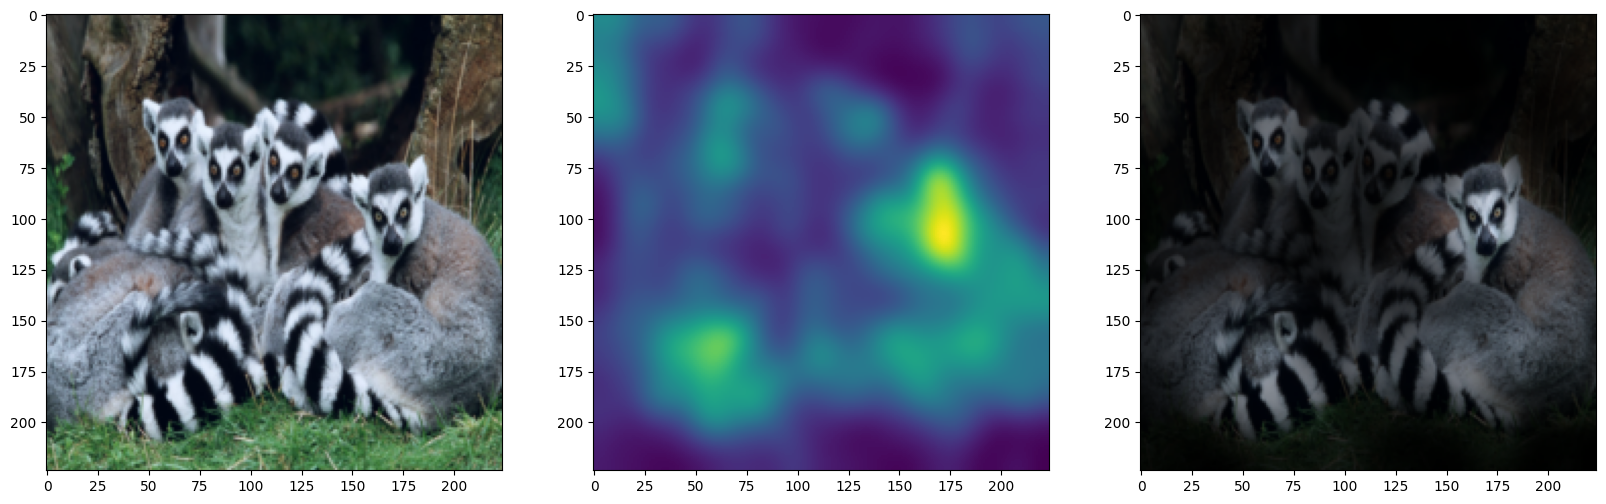

In [62]:
fig = plt.figure()
ax = fig.add_subplot(1,3,1)
ax.imshow(image)
ax = fig.add_subplot(1,3,2)
ax.imshow(heatmap[:,:,0])
ax = fig.add_subplot(1,3,3)
ax.imshow((image * heatmap).astype(np.uint8))

Посмотрим, что происходит с активациями в конкретной карте активаций

In [66]:
submodel = nn.Sequential(*list(model.features)[:(17+1)])

In [67]:
submodel

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [68]:
conv17_output = submodel(img_tensor)

In [69]:
conv17_output.shape

torch.Size([1, 512, 28, 28])

In [70]:
x1 = conv17_output[0,42,...].detach().cpu().numpy()

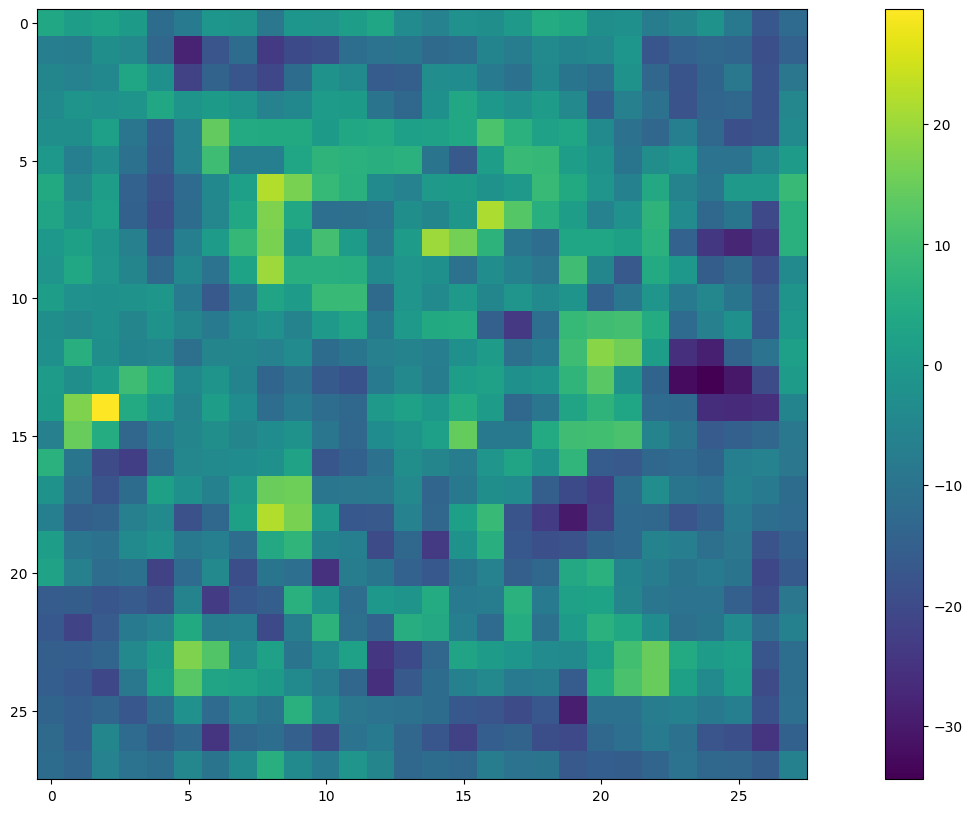

In [71]:
plt.imshow(x1)
plt.colorbar();

In [72]:
conv17_output[0,42,14,2]

tensor(29.5285, device='cuda:0', grad_fn=<SelectBackward0>)

В следующей демонстрации мы посмотрим, что такого должно произойти в изображении, чтобы "загорелся" этот конкретный пиксель карты активаций.